# Kalman Filter for Hurricane Track Prediction

Implementation of a Kalman filter state-space model for predicting hurricane tracks using sequential Bayesian inference.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load processed dataset
df = pd.read_pickle("hurricane_paths_processed.pkl")
df = df.sort_values(['sid', 'iso_time']).reset_index(drop=True)

# Check for metric coordinates
has_metric = 'x_km' in df.columns and 'y_km' in df.columns
if not has_metric:
    print("Warning: Metric coordinates not found. Please run feature engineering first.")
else:
    print(f"Loaded dataset with {len(df):,} observations from {df['sid'].nunique():,} storms")
    print(f"Metric coordinates available: x_km, y_km, vx_km, vy_km")


Loaded dataset with 721,960 observations from 13,450 storms
Metric coordinates available: x_km, y_km, vx_km, vy_km


In [3]:
# Train/test split at storm level
from sklearn.model_selection import train_test_split

# Filter to storms with metric coordinates and sufficient observations
if has_metric:
    valid_storms = df[df.groupby('sid')['sid'].transform('count') >= 3]['sid'].unique()
    df_modeling = df[df['sid'].isin(valid_storms)].copy()
else:
    df_modeling = df.copy()

# Split storms into train/test (80/20)
unique_storms = df_modeling['sid'].unique()
train_storms, test_storms = train_test_split(
    unique_storms, test_size=0.2, random_state=42
)

df_train = df_modeling[df_modeling['sid'].isin(train_storms)].copy()
df_test = df_modeling[df_modeling['sid'].isin(test_storms)].copy()

print(f"Training storms: {len(train_storms)} ({len(df_train):,} observations)")
print(f"Test storms: {len(test_storms)} ({len(df_test):,} observations)")


Training storms: 10759 (577,711 observations)
Test storms: 2690 (144,247 observations)


In [4]:
class HurricaneKalmanFilter:
    """Kalman filter for hurricane track prediction with feature-adaptive parameters
    
    State vector: [x_km, y_km, vx_km, vy_km] in metric coordinates (km)
    - x_km: east-west position in km (relative to storm start)
    - y_km: north-south position in km (relative to storm start)
    - vx_km: east-west velocity in km per 6 hours
    - vy_km: north-south velocity in km per 6 hours
    
    Observation: [x_km, y_km]
    """
    
    def __init__(self, q_base=None, r_base=None, adaptive=True):
        # State: [x_km, y_km, vx_km, vy_km] (all in km units)
        # Observation: [x_km, y_km]
        
        # Transition matrix A: constant velocity model
        self.A = np.array([
            [1, 0, 1, 0],  # x_{t+1} = x_t + vx
            [0, 1, 0, 1],  # y_{t+1} = y_t + vy
            [0, 0, 1, 0],  # vx_{t+1} = vx_t
            [0, 0, 0, 1]   # vy_{t+1} = vy_t
        ])
        
        # Observation matrix H: maps state to observations
        self.H = np.array([
            [1, 0, 0, 0],  # observe x
            [0, 1, 0, 0]   # observe y
        ])
        
        # Base process noise covariance Q (estimated from training data, in km²)
        # Default values in km units
        if q_base is None:
            self.Q_base = np.array([
                [1.0, 0, 0, 0],      # position noise: 1 km²
                [0, 1.0, 0, 0],
                [0, 0, 10.0, 0],     # velocity noise: 10 (km/6h)²
                [0, 0, 0, 10.0]
            ])
        else:
            self.Q_base = q_base.copy()
        
        # Base observation noise covariance R (in km²)
        if r_base is None:
            self.R_base = np.array([
                [0.25, 0],    # observation noise: 0.5 km std (0.25 km²)
                [0, 0.25]
            ])
        else:
            self.R_base = r_base.copy()
        
        self.adaptive = adaptive
        self.Q = self.Q_base.copy()
        self.R = self.R_base.copy()
        
    def adapt_parameters(self, features):
        """Adapt Q and R based on storm features"""
        if not self.adaptive:
            return
        
        q_scale = 1.0
        r_scale = 1.0
        
        # Helper function to safely get scalar value from features dict
        def get_scalar(key, default=0):
            val = features.get(key, default)
            # Convert to scalar if it's a Series or array
            if hasattr(val, 'iloc'):
                val = val.iloc[0] if len(val) > 0 else default
            elif isinstance(val, (list, np.ndarray)) and len(val) > 0:
                val = val[0]
            return val
        
        # Higher Q when curvature is high (turning)
        if 'track_curvature' in features:
            curvature_val = get_scalar('track_curvature', np.nan)
            if not pd.isna(curvature_val):
                curvature = abs(float(curvature_val))
                q_scale *= (1 + min(curvature * 0.5, 2.0))  # Up to 3x when high curvature
        
        # Higher Q when approaching land
        if 'is_approaching_land' in features:
            land_val = get_scalar('is_approaching_land', 0)
            if land_val == 1:
                q_scale *= 1.5
        
        # Higher Q for different motion regimes
        if 'motion_regime' in features:
            regime = get_scalar('motion_regime', 0)
            if regime == 2:  # Poleward/recurving
                q_scale *= 1.3
            elif regime == 0:  # Westward
                q_scale *= 1.1
        
        # Higher Q for different latitude regimes
        if 'latitude_regime' in features:
            regime = get_scalar('latitude_regime', 0)
            if regime == 2:  # Mid-latitudes
                q_scale *= 1.2
        
        # Apply scaling
        self.Q = self.Q_base * q_scale
        self.R = self.R_base * r_scale
        
    def initialize(self, initial_state, initial_covariance=None):
        """Initialize filter with first state estimate"""
        self.x = initial_state.copy()
        if initial_covariance is None:
            self.P = np.eye(4) * 0.1
        else:
            self.P = initial_covariance.copy()
    
    def predict(self):
        """Prediction step: forecast next state"""
        self.x_pred = self.A @ self.x
        self.P_pred = self.A @ self.P @ self.A.T + self.Q
        return self.x_pred.copy(), self.P_pred.copy()
    
    def update(self, observation):
        """Update step: incorporate new observation"""
        y = observation
        y_pred = self.H @ self.x_pred
        
        # Innovation (measurement residual)
        innovation = y - y_pred
        
        # Innovation covariance
        S = self.H @ self.P_pred @ self.H.T + self.R
        
        # Kalman gain
        K = self.P_pred @ self.H.T @ inv(S)
        
        # Updated state estimate
        self.x = self.x_pred + K @ innovation
        
        # Updated covariance
        self.P = (np.eye(4) - K @ self.H) @ self.P_pred
        
        return self.x.copy(), self.P.copy()
    
    def forecast(self, n_steps=1):
        """Generate n-step ahead forecast"""
        x_forecast = self.x.copy()
        P_forecast = self.P.copy()
        forecasts = []
        
        for _ in range(n_steps):
            x_forecast = self.A @ x_forecast
            P_forecast = self.A @ P_forecast @ self.A.T + self.Q
            forecasts.append((x_forecast.copy(), P_forecast.copy()))
        
        return forecasts


In [5]:
def run_kalman_filter_on_storm(storm_data, kf, use_features=True):
    """Run Kalman filter on a single storm track with optional feature adaptation
    
    Uses metric coordinates: x_km, y_km, vx_km, vy_km
    """
    storm_data = storm_data.sort_values('iso_time').reset_index(drop=True)
    
    # Check if metric coordinates exist
    has_metric = 'x_km' in storm_data.columns and 'y_km' in storm_data.columns
    
    if not has_metric:
        raise ValueError("Metric coordinates (x_km, y_km, vx_km, vy_km) not found. "
                        "Please run feature engineering with metric conversion.")
    
    # Initialize with first observation in metric coordinates
    initial_state = np.array([
        storm_data['x_km'].iloc[0],
        storm_data['y_km'].iloc[0],
        storm_data['vx_km'].iloc[0] if not pd.isna(storm_data['vx_km'].iloc[0]) else 0.0,
        storm_data['vy_km'].iloc[0] if not pd.isna(storm_data['vy_km'].iloc[0]) else 0.0
    ])
    kf.initialize(initial_state)
    
    # Get feature columns if available
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    has_features = use_features and all(col in storm_data.columns for col in feature_cols)
    
    states = []
    predictions = []
    observations = []
    covariances = []
    
    for i in range(len(storm_data)):
        # Observation in metric coordinates (km)
        obs = np.array([
            storm_data['x_km'].iloc[i],
            storm_data['y_km'].iloc[i]
        ])
        observations.append(obs)
        
        if i == 0:
            # Adapt parameters for first time step
            if has_features:
                # Extract features as scalars (access each column directly)
                features = {col: storm_data[col].iloc[i] for col in feature_cols}
                kf.adapt_parameters(features)
            
            states.append(kf.x.copy())
            predictions.append(kf.x[:2].copy())
            covariances.append(kf.P.copy())
        else:
            # Adapt parameters before prediction
            if has_features:
                # Extract features as scalars (access each column directly)
                features = {col: storm_data[col].iloc[i] for col in feature_cols}
                kf.adapt_parameters(features)
            
            pred, P_pred = kf.predict()
            predictions.append(pred[:2].copy())
            
            updated, P_updated = kf.update(obs)
            states.append(updated.copy())
            covariances.append(P_updated.copy())
    
    return {
        'states': np.array(states),  # [x, y, vx, vy] in km
        'predictions': np.array(predictions),  # [x, y] in km
        'observations': np.array(observations),  # [x, y] in km
        'covariances': np.array(covariances),
        'times': storm_data['iso_time'].values,
        'lat_ref': storm_data['lat_ref'].iloc[0] if 'lat_ref' in storm_data.columns else None,
        'lon_ref': storm_data['lon_ref'].iloc[0] if 'lon_ref' in storm_data.columns else None
    }


In [7]:
# Estimate Q and R from training data
def estimate_noise_covariances(df_train, min_storm_length=5, sample_size=None):
    """Estimate process noise Q and observation noise R from training data"""
    valid_storms = df_train[df_train.groupby('sid')['sid'].transform('count') >= min_storm_length]['sid'].unique()
    
    if sample_size is not None and len(valid_storms) > sample_size:
        valid_storms = valid_storms[:sample_size]
    
    state_changes = []
    obs_residuals = []
    
    for sid in valid_storms:
        storm = df_train[df_train['sid'] == sid].sort_values('iso_time')
        storm = storm.reset_index(drop=True)
        
        if len(storm) < 2:
            continue
        
        # Check if metric coordinates exist
        if 'x_km' not in storm.columns or 'y_km' not in storm.columns:
            continue  # Skip storms without metric coordinates
        
        # Estimate Q from actual state transitions vs predicted (constant velocity model)
        for i in range(1, len(storm)):
            # Previous state in metric coordinates (km)
            state_t = np.array([
                storm['x_km'].iloc[i-1],
                storm['y_km'].iloc[i-1],
                storm['vx_km'].iloc[i-1] if not pd.isna(storm['vx_km'].iloc[i-1]) else 0.0,
                storm['vy_km'].iloc[i-1] if not pd.isna(storm['vy_km'].iloc[i-1]) else 0.0
            ])
            
            # Actual next state
            state_t1_actual = np.array([
                storm['x_km'].iloc[i],
                storm['y_km'].iloc[i],
                storm['vx_km'].iloc[i] if not pd.isna(storm['vx_km'].iloc[i]) else 0.0,
                storm['vy_km'].iloc[i] if not pd.isna(storm['vy_km'].iloc[i]) else 0.0
            ])
            
            # Predicted next state (constant velocity)
            A = np.array([
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ])
            state_t1_pred = A @ state_t
            
            # Innovation (process noise) in km units
            innovation = state_t1_actual - state_t1_pred
            state_changes.append(innovation)
        
        # Estimate R from observation residuals (actual filtered vs observed positions)
        # Run a filter on this storm to get filtered states, then compare to observations
        temp_kf = HurricaneKalmanFilter()
        temp_state = np.array([
            storm['x_km'].iloc[0], storm['y_km'].iloc[0],
            storm['vx_km'].iloc[0] if not pd.isna(storm['vx_km'].iloc[0]) else 0.0,
            storm['vy_km'].iloc[0] if not pd.isna(storm['vy_km'].iloc[0]) else 0.0
        ])
        temp_kf.initialize(temp_state)
        
        # Run filter and collect observation residuals (innovation)
        for i in range(1, len(storm)):
            obs = np.array([storm['x_km'].iloc[i], storm['y_km'].iloc[i]])
            pred, _ = temp_kf.predict()
            innovation = obs - (temp_kf.H @ pred)
            obs_residuals.append(innovation)
            temp_kf.update(obs)
    
    if len(state_changes) > 0 and len(obs_residuals) > 0:
        # Estimate Q covariance
        state_changes_array = np.array(state_changes)
        Q_est = np.cov(state_changes_array.T)
        
        # Ensure Q is positive definite (add small regularization)
        Q_est = Q_est + np.eye(4) * 1e-6
        
        # Estimate R from observation residuals (innovation covariance)
        obs_residuals_array = np.array(obs_residuals)
        R_est = np.cov(obs_residuals_array.T)
        
        # Ensure R is positive definite and reasonable (best-track uncertainty)
        R_est = R_est + np.eye(2) * 1e-6
        # Cap minimum observation noise (best-track has ~0.5-1 km uncertainty)
        min_obs_noise = 0.25  # 0.5 km std
        R_est = np.maximum(R_est, np.eye(2) * min_obs_noise)
        
        return Q_est, R_est
    
    return None, None

# Estimate parameters from training data
Q_est, R_est = estimate_noise_covariances(df_train, sample_size=200)

if Q_est is not None:
    print("Estimated noise covariances from training data:")
    print(f"Q (process noise):\n{Q_est}")
    print(f"\nR (observation noise):\n{R_est}")
    
    # Create filter with estimated parameters
    kf_estimated = HurricaneKalmanFilter(q_base=Q_est, r_base=R_est, adaptive=True)
else:
    print("Could not estimate parameters. Using default values.")
    kf_estimated = HurricaneKalmanFilter(adaptive=True)


Estimated noise covariances from training data:
Q (process noise):
[[2859.84424925  542.25405843  389.66793801  -15.87515565]
 [ 542.25405843 1678.39113123  -51.67770167  260.23061083]
 [ 389.66793801  -51.67770167  735.04799246   64.88834523]
 [ -15.87515565  260.23061083   64.88834523  442.07522514]]

R (observation noise):
[[264.924489    16.35441209]
 [ 16.35441209 168.61458652]]


In [8]:
def compute_forecast_errors(results):
    """Compute forecast errors from Kalman filter results
    
    Both predictions and observations are in metric coordinates (km),
    so error calculation is straightforward.
    """
    predictions = results['predictions'][1:]  # Skip first (no prediction)
    observations = results['observations'][1:]
    
    if len(predictions) == 0:
        return None
    
    # Errors in km (already in metric coordinates)
    errors = predictions - observations
    distances = np.sqrt(errors[:, 0]**2 + errors[:, 1]**2)  # Already in km
    
    return {
        'x_errors': errors[:, 0],  # east-west error in km
        'y_errors': errors[:, 1],      # north-south error in km
        'distances_km': distances,      # total distance error in km
        'mean_error_km': np.mean(distances),
        'rmse_km': np.sqrt(np.mean(distances**2)),
        'median_error_km': np.median(distances)
    }


In [9]:
# Test on a single test storm
test_storm_id = df_test[df_test.groupby('sid')['sid'].transform('count') >= 10]['sid'].iloc[0]
test_storm = df_test[df_test['sid'] == test_storm_id].copy()

# Test with estimated parameters and feature adaptation
results = run_kalman_filter_on_storm(test_storm, kf_estimated, use_features=True)
errors = compute_forecast_errors(results)

print(f"Test storm: {test_storm_id}")
print(f"Observations: {len(test_storm)}")
if errors:
    print(f"Mean forecast error: {errors['mean_error_km']:.2f} km")
    print(f"RMSE: {errors['rmse_km']:.2f} km")
    print(f"Median error: {errors['median_error_km']:.2f} km")


Test storm: 1842298N11080
Observations: 65
Mean forecast error: 10.15 km
RMSE: 13.37 km
Median error: 8.25 km


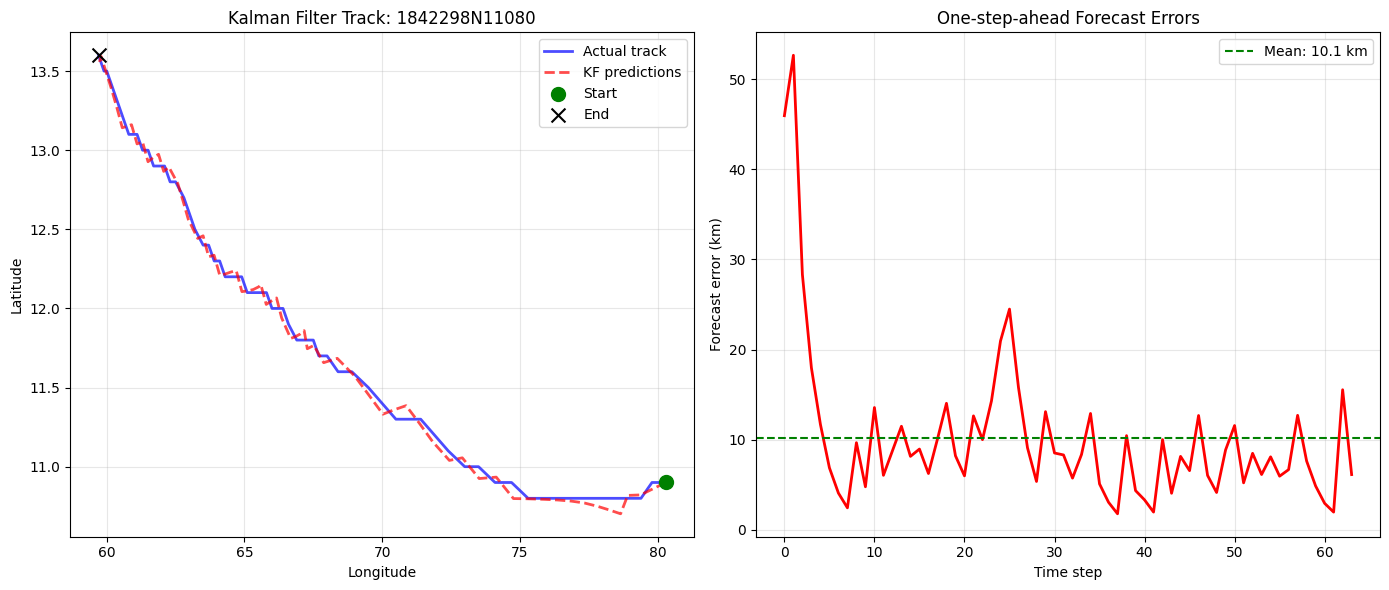

In [10]:
# Visualize filter results for test storm
# Convert metric coordinates back to lat/lon for visualization
def metric_to_latlon(x_km, y_km, lat_ref, lon_ref):
    """Convert metric coordinates back to lat/lon"""
    R_EARTH = 111.0  # km per degree
    lat = lat_ref + y_km / R_EARTH
    lon = lon_ref + x_km / (R_EARTH * np.cos(np.radians(lat_ref)))
    return lat, lon

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Track plot (convert to lat/lon for display)
ax = axes[0]
actual_track_km = results['observations']
predicted_track_km = results['predictions']

if results.get('lat_ref') and results.get('lon_ref'):
    lat_ref = results['lat_ref']
    lon_ref = results['lon_ref']
    
    # Convert to lat/lon
    actual_lat, actual_lon = metric_to_latlon(
        actual_track_km[:, 0], actual_track_km[:, 1], lat_ref, lon_ref
    )
    pred_lat, pred_lon = metric_to_latlon(
        predicted_track_km[:, 0], predicted_track_km[:, 1], lat_ref, lon_ref
    )
    
    ax.plot(actual_lon, actual_lat, 'b-', linewidth=2, label='Actual track', alpha=0.7)
    ax.plot(pred_lon, pred_lat, 'r--', linewidth=2, label='KF predictions', alpha=0.7)
    ax.scatter(actual_lon[0], actual_lat[0], color='green', s=100, marker='o', label='Start', zorder=5)
    ax.scatter(actual_lon[-1], actual_lat[-1], color='black', s=100, marker='x', label='End', zorder=5)
else:
    # Fallback: plot in metric coordinates
    ax.plot(actual_track_km[:, 0], actual_track_km[:, 1], 'b-', linewidth=2, label='Actual track', alpha=0.7)
    ax.plot(predicted_track_km[:, 0], predicted_track_km[:, 1], 'r--', linewidth=2, label='KF predictions', alpha=0.7)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

ax.set_xlabel('Longitude' if results.get('lat_ref') else 'x (km)')
ax.set_ylabel('Latitude' if results.get('lat_ref') else 'y (km)')
ax.set_title(f'Kalman Filter Track: {test_storm_id}')
ax.grid(True, alpha=0.3)
ax.legend()

# Error plot
if errors:
    ax = axes[1]
    ax.plot(errors['distances_km'], 'r-', linewidth=2)
    ax.axhline(y=errors['mean_error_km'], color='g', linestyle='--', label=f'Mean: {errors["mean_error_km"]:.1f} km')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Forecast error (km)')
    ax.set_title('One-step-ahead Forecast Errors')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


In [12]:
# Evaluate on multiple storms
def evaluate_on_storms(df_eval, storm_ids, kf, use_features=True):
    """Evaluate Kalman filter on multiple storms"""
    all_errors = []
    
    for sid in storm_ids:
        storm = df_eval[df_eval['sid'] == sid].copy()
        if len(storm) < 3:
            continue
        
        # Create new filter instance for each storm (parameters are adapted during filtering)
        storm_kf = HurricaneKalmanFilter(q_base=kf.Q_base, r_base=kf.R_base, adaptive=kf.adaptive)
        
        results = run_kalman_filter_on_storm(storm, storm_kf, use_features=use_features)
        errors = compute_forecast_errors(results)
        
        if errors:
            all_errors.append({
                'sid': sid,
                'n_obs': len(storm),
                'mean_error': errors['mean_error_km'],
                'rmse': errors['rmse_km'],
                'median_error': errors['median_error_km']
            })
    
    return pd.DataFrame(all_errors)

# Evaluate on test set
test_eval_storms = df_test[df_test.groupby('sid')['sid'].transform('count') >= 5]['sid'].unique()

print("Evaluating on test set...")
test_results = evaluate_on_storms(df_test, test_eval_storms, kf_estimated, use_features=True)

if len(test_results) > 0:
    print(f"\nTest set evaluation ({len(test_results)} storms):")
    print(f"Mean forecast error: {test_results['mean_error'].mean():.2f} km")
    print(f"RMSE: {test_results['rmse'].mean():.2f} km")
    print(f"Median error: {test_results['median_error'].mean():.2f} km")
    print(f"\nError distribution:")
    print(test_results[['mean_error', 'rmse', 'median_error']].describe())


Evaluating on test set...

Test set evaluation (2680 storms):
Mean forecast error: 21.13 km
RMSE: 26.85 km
Median error: 16.85 km

Error distribution:
        mean_error         rmse  median_error
count  2680.000000  2680.000000   2680.000000
mean     21.134603    26.849765     16.851195
std      12.070470    16.039751     10.752457
min       5.049026     6.960703      0.000000
25%      13.793341    16.867099     11.102551
50%      18.475809    23.338814     14.554625
75%      25.137717    32.254400     19.289760
max     203.018000   221.927132    217.259470


In [13]:
# Estimate Q and R from training data
def estimate_noise_covariances(df_train, min_storm_length=5, sample_size=None):
    """Estimate process noise Q and observation noise R from training data"""
    valid_storms = df_train[df_train.groupby('sid')['sid'].transform('count') >= min_storm_length]['sid'].unique()
    
    if sample_size is not None and len(valid_storms) > sample_size:
        valid_storms = valid_storms[:sample_size]
    
    state_changes = []
    obs_residuals = []
    
    for sid in valid_storms:
        storm = df_train[df_train['sid'] == sid].sort_values('iso_time')
        storm = storm.reset_index(drop=True)
        
        if len(storm) < 2:
            continue
        
        # Check if metric coordinates exist
        if 'x_km' not in storm.columns or 'y_km' not in storm.columns:
            continue  # Skip storms without metric coordinates
        
        # Estimate Q from actual state transitions vs predicted (constant velocity model)
        for i in range(1, len(storm)):
            # Previous state in metric coordinates (km)
            state_t = np.array([
                storm['x_km'].iloc[i-1],
                storm['y_km'].iloc[i-1],
                storm['vx_km'].iloc[i-1] if not pd.isna(storm['vx_km'].iloc[i-1]) else 0.0,
                storm['vy_km'].iloc[i-1] if not pd.isna(storm['vy_km'].iloc[i-1]) else 0.0
            ])
            
            # Actual next state
            state_t1_actual = np.array([
                storm['x_km'].iloc[i],
                storm['y_km'].iloc[i],
                storm['vx_km'].iloc[i] if not pd.isna(storm['vx_km'].iloc[i]) else 0.0,
                storm['vy_km'].iloc[i] if not pd.isna(storm['vy_km'].iloc[i]) else 0.0
            ])
            
            # Predicted next state (constant velocity)
            A = np.array([
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ])
            state_t1_pred = A @ state_t
            
            # Innovation (process noise) in km units
            innovation = state_t1_actual - state_t1_pred
            state_changes.append(innovation)
        
        # Estimate R from observation residuals (position measurement error in km²)
        # Use small value for best-track data (highly accurate: ~0.5 km std)
        obs_residuals.append([0.25, 0.25])  # 0.5 km std = 0.25 km² variance
    
    if len(state_changes) > 0:
        # Estimate Q covariance
        state_changes_array = np.array(state_changes)
        Q_est = np.cov(state_changes_array.T)
        
        # Ensure Q is positive definite (add small regularization)
        Q_est = Q_est + np.eye(4) * 1e-6
        
        # Estimate R (observation noise is typically small for best-track)
        R_est = np.eye(2) * np.mean(obs_residuals)
        
        return Q_est, R_est
    
    return None, None

# Estimate parameters from training data
Q_est, R_est = estimate_noise_covariances(df_train, sample_size=200)

if Q_est is not None:
    print("Estimated noise covariances from training data:")
    print(f"Q (process noise):\n{Q_est}")
    print(f"\nR (observation noise):\n{R_est}")
    
    # Create filter with estimated parameters
    kf_estimated = HurricaneKalmanFilter(q_base=Q_est, r_base=R_est, adaptive=True)
else:
    print("Could not estimate parameters. Using default values.")
    kf_estimated = HurricaneKalmanFilter(adaptive=True)


Estimated noise covariances from training data:
Q (process noise):
[[2859.84424925  542.25405843  389.66793801  -15.87515565]
 [ 542.25405843 1678.39113123  -51.67770167  260.23061083]
 [ 389.66793801  -51.67770167  735.04799246   64.88834523]
 [ -15.87515565  260.23061083   64.88834523  442.07522514]]

R (observation noise):
[[0.25 0.  ]
 [0.   0.25]]


In [15]:
# Generate multiple forecast paths for spaghetti plots
def generate_forecast_paths(kf, n_steps, n_paths=50):
    """Generate multiple forecast paths using Monte Carlo simulation"""
    paths = []
    
    for _ in range(n_paths):
        x_sample = np.random.multivariate_normal(kf.x, kf.P)
        path = [x_sample[:2].copy()]
        
        x = x_sample.copy()
        P = kf.P.copy()
        
        for _ in range(n_steps):
            # Predict
            x = kf.A @ x
            P = kf.A @ P @ kf.A.T + kf.Q
            
            # Sample from prediction distribution
            x = np.random.multivariate_normal(x, P)
            path.append(x[:2].copy())
        
        paths.append(np.array(path))
    
    return np.array(paths)

# Example: Generate forecast paths for test storm
# Use filter with estimated parameters
forecast_kf = HurricaneKalmanFilter(q_base=kf_estimated.Q_base, r_base=kf_estimated.R_base, adaptive=kf_estimated.adaptive)
initial_state = np.array([
    test_storm['lat'].iloc[-1],
    test_storm['lon'].iloc[-1],
    test_storm['v_lat'].iloc[-1],
    test_storm['v_lon'].iloc[-1]
])
forecast_kf.initialize(initial_state)

spaghetti_paths = generate_forecast_paths(forecast_kf, n_steps=8, n_paths=50)


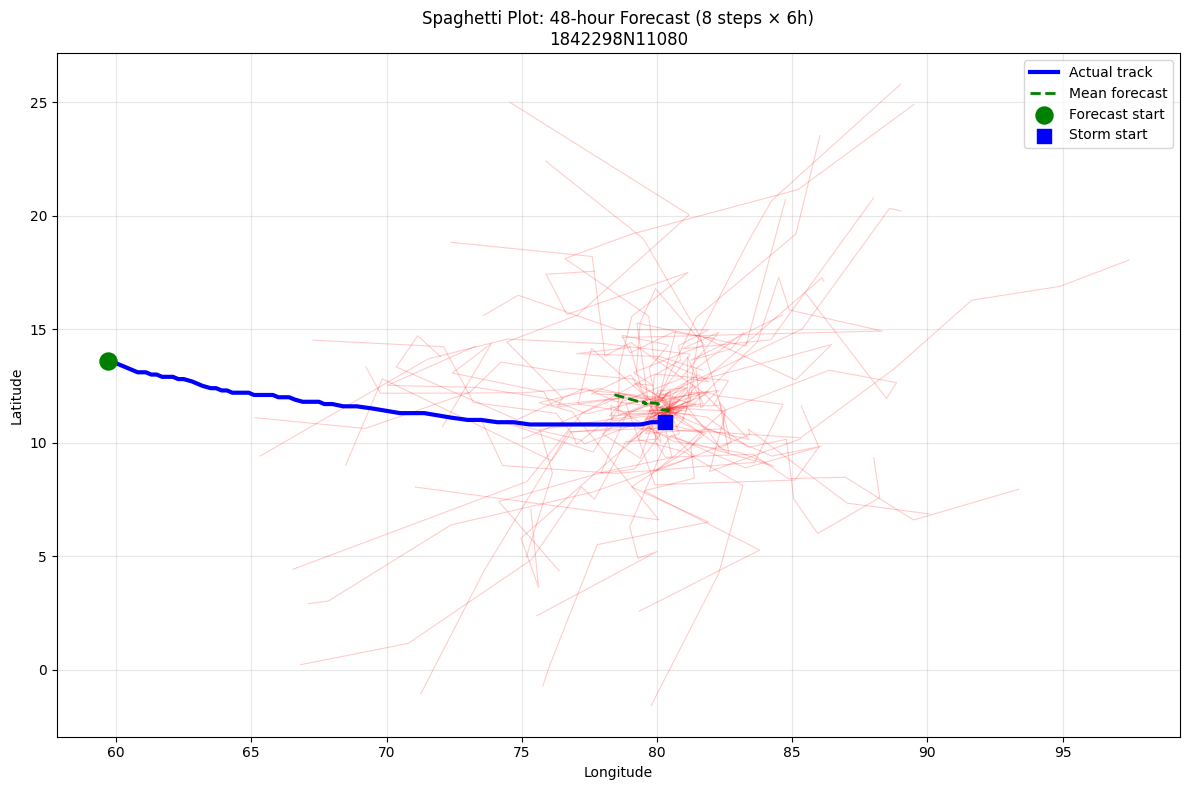

In [16]:
# Visualize spaghetti plot
if len(spaghetti_paths) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Convert metric coordinates to lat/lon for display if reference points exist
    if 'lat_ref' in test_storm.columns and 'lon_ref' in test_storm.columns:
        lat_ref = test_storm['lat_ref'].iloc[0]
        lon_ref = test_storm['lon_ref'].iloc[0]
        
        def metric_to_latlon_spaghetti(x_km, y_km):
            R_EARTH = 111.0
            lat = lat_ref + y_km / R_EARTH
            lon = lon_ref + x_km / (R_EARTH * np.cos(np.radians(lat_ref)))
            return lat, lon
        
        # Convert actual track
        actual_lat, actual_lon = metric_to_latlon_spaghetti(
            test_storm['x_km'].values, test_storm['y_km'].values
        )
        ax.plot(actual_lon, actual_lat, 
                'b-', linewidth=3, label='Actual track', zorder=10)
        
        # Convert forecast paths
        for path in spaghetti_paths:
            path_lat, path_lon = metric_to_latlon_spaghetti(path[:, 0], path[:, 1])
            ax.plot(path_lon, path_lat, 'r-', alpha=0.2, linewidth=0.8)
        
        # Convert mean forecast
        mean_path = np.mean(spaghetti_paths, axis=0)
        mean_lat, mean_lon = metric_to_latlon_spaghetti(mean_path[:, 0], mean_path[:, 1])
        ax.plot(mean_lon, mean_lat, 'g--', linewidth=2, 
                label='Mean forecast', zorder=5)
        
        # Start and end markers
        ax.scatter(actual_lon[-1], actual_lat[-1],
                  color='green', s=150, marker='o', label='Forecast start', zorder=15)
        ax.scatter(actual_lon[0], actual_lat[0],
                  color='blue', s=100, marker='s', label='Storm start', zorder=15)
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    else:
        # Fallback: plot in metric coordinates
        ax.plot(test_storm['x_km'].values, test_storm['y_km'].values, 
                'b-', linewidth=3, label='Actual track', zorder=10)
        
        for path in spaghetti_paths:
            ax.plot(path[:, 0], path[:, 1], 'r-', alpha=0.2, linewidth=0.8)
        
        mean_path = np.mean(spaghetti_paths, axis=0)
        ax.plot(mean_path[:, 0], mean_path[:, 1], 'g--', linewidth=2, 
                label='Mean forecast', zorder=5)
        
        ax.scatter(test_storm['x_km'].iloc[-1], test_storm['y_km'].iloc[-1],
                  color='green', s=150, marker='o', label='Forecast start', zorder=15)
        ax.scatter(test_storm['x_km'].iloc[0], test_storm['y_km'].iloc[0],
                  color='blue', s=100, marker='s', label='Storm start', zorder=15)
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
    
    ax.set_title(f'Spaghetti Plot: 48-hour Forecast (8 steps × 6h)\n{test_storm_id}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [17]:
# ============================================================================
# OLD EVALUATION FUNCTION (FILTERING, NOT TRUE FORECASTING)
# ============================================================================
# NOTE: This function evaluates filtering accuracy (with updates at every step),
# NOT open-loop forecasting accuracy. For true forecast evaluation, use:
# - open_loop_forecast() for single forecasts
# - evaluate_sliding_origins() for comprehensive evaluation
# ============================================================================

# Evaluate forecast accuracy at different lead times (OLD - FILTERING MODE)
def evaluate_lead_time_accuracy(df_eval, storm_ids, kf, max_lead_steps=8, use_features=True):
    """Evaluate forecast accuracy at different lead times (6h, 12h, 18h, etc.)"""
    lead_time_errors = {step: [] for step in range(1, max_lead_steps + 1)}
    
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    has_features = use_features and all(col in df_eval.columns for col in feature_cols)
    
    for sid in storm_ids:
        storm = df_eval[df_eval['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
        if len(storm) < max_lead_steps + 1:
            continue
        
        # Check if metric coordinates exist
        if 'x_km' not in storm.columns or 'y_km' not in storm.columns:
            continue
        
        # Create new filter instance
        storm_kf = HurricaneKalmanFilter(q_base=kf.Q_base, r_base=kf.R_base, adaptive=kf.adaptive)
        initial_state = np.array([
            storm['x_km'].iloc[0], storm['y_km'].iloc[0],
            storm['vx_km'].iloc[0] if not pd.isna(storm['vx_km'].iloc[0]) else 0.0,
            storm['vy_km'].iloc[0] if not pd.isna(storm['vy_km'].iloc[0]) else 0.0
        ])
        storm_kf.initialize(initial_state)
        
        for t in range(1, min(len(storm), max_lead_steps + 1)):
            obs_t = np.array([storm['x_km'].iloc[t], storm['y_km'].iloc[t]])
            
            # Adapt parameters before prediction
            if has_features:
                features = storm.iloc[t][feature_cols].to_dict()
                storm_kf.adapt_parameters(features)
            
            # Predict t steps ahead from time 0
            if t == 1:
                pred, _ = storm_kf.predict()
                storm_kf.update(obs_t)
            else:
                # For multi-step, run filter up to t-1, then predict 1 step
                for i in range(1, t):
                    obs_i = np.array([storm['x_km'].iloc[i], storm['y_km'].iloc[i]])
                    
                    if has_features:
                        features_i = storm.iloc[i][feature_cols].to_dict()
                        storm_kf.adapt_parameters(features_i)
                    
                    storm_kf.predict()
                    storm_kf.update(obs_i)
                
                pred, _ = storm_kf.predict()
                storm_kf.update(obs_t)
            
            # Error already in km (metric coordinates)
            error = np.sqrt((pred[0] - obs_t[0])**2 + (pred[1] - obs_t[1])**2)
            lead_time_errors[t].append(error)
    
    # Compute statistics
    results = {}
    for step, errors in lead_time_errors.items():
        if len(errors) > 0:
            results[f'{step*6}h'] = {
                'mean': np.mean(errors),
                'median': np.median(errors),
                'rmse': np.sqrt(np.mean(np.array(errors)**2))
            }
    
    return pd.DataFrame(results).T

# Evaluate lead time accuracy on test set
print("Evaluating lead time accuracy on test set...")
test_sample = test_eval_storms[:50]  # Sample for speed
lead_time_results = evaluate_lead_time_accuracy(df_test, test_sample, kf_estimated, max_lead_steps=8, use_features=True)

if len(lead_time_results) > 0:
    print("\nForecast accuracy by lead time (test set):")
    print(lead_time_results)


Evaluating lead time accuracy on test set...

Forecast accuracy by lead time (test set):
          mean     median       rmse
6h   38.234466  32.473615  45.704072
12h  13.860866  11.894666  16.747572
18h  18.074283  18.784318  20.608554
24h  21.881726  17.124279  31.451224
30h  17.533726  13.788643  22.824089
36h  17.027435  15.169674  22.294790
42h  11.817636  11.044667  13.806070
48h  11.133435  10.378000  12.376806


In [18]:
# ============================================================================
# PROPER OPEN-LOOP FORECASTING FUNCTIONS
# ============================================================================
# These functions implement true forecasting (no updates after initialization)

def initialize_filter_from_observations(storm_data, kf, t0_idx, use_features=True):
    """Initialize filter using observations up to time t0_idx, then return initialized filter
    
    This runs the filter with updates ONLY up to t0_idx, then returns the filter
    in its state at t0_idx. This is used as the starting point for open-loop forecasting.
    """
    storm_data = storm_data.sort_values('iso_time').reset_index(drop=True)
    
    if 'x_km' not in storm_data.columns or 'y_km' not in storm_data.columns:
        raise ValueError("Metric coordinates required")
    
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    has_features = use_features and all(col in storm_data.columns for col in feature_cols)
    
    # Initialize with first observation
    initial_state = np.array([
        storm_data['x_km'].iloc[0],
        storm_data['y_km'].iloc[0],
        storm_data['vx_km'].iloc[0] if not pd.isna(storm_data['vx_km'].iloc[0]) else 0.0,
        storm_data['vy_km'].iloc[0] if not pd.isna(storm_data['vy_km'].iloc[0]) else 0.0
    ])
    kf.initialize(initial_state)
    
    # Run filter with updates up to t0_idx
    for i in range(1, min(t0_idx + 1, len(storm_data))):
        obs = np.array([storm_data['x_km'].iloc[i], storm_data['y_km'].iloc[i]])
        
        # Adapt parameters if using features
        if has_features:
            features = {col: storm_data[col].iloc[i] for col in feature_cols}
            kf.adapt_parameters(features)
        
        # Predict and update
        kf.predict()
        kf.update(obs)
    
    return kf

def open_loop_forecast(storm_data, kf, t0_idx, lead_steps, use_features=True):
    """Generate open-loop forecast: initialize from observations up to t0_idx, 
    then forecast lead_steps ahead WITHOUT any updates.
    
    Args:
        storm_data: Storm track data
        kf: KalmanFilter instance (will be modified)
        t0_idx: Index of forecast origin (uses observations up to this point)
        lead_steps: Number of steps ahead to forecast
        use_features: Whether to adapt parameters during initialization phase
    
    Returns:
        Dictionary with forecasts, true observations, and errors
    """
    storm_data = storm_data.sort_values('iso_time').reset_index(drop=True)
    
    # Create a fresh filter instance
    forecast_kf = HurricaneKalmanFilter(q_base=kf.Q_base, r_base=kf.R_base, adaptive=kf.adaptive)
    
    # Initialize filter using observations up to t0_idx
    initialize_filter_from_observations(storm_data, forecast_kf, t0_idx, use_features)
    
    # Now do open-loop forecasting (no updates)
    forecasts = []
    true_observations = []
    
    x_current = forecast_kf.x.copy()
    P_current = forecast_kf.P.copy()
    
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    has_features = use_features and all(col in storm_data.columns for col in feature_cols)
    
    for step in range(1, lead_steps + 1):
        t_target = t0_idx + step
        
        if t_target >= len(storm_data):
            break
        
        # Adapt parameters if using features (use features from previous step if available)
        if has_features and t_target > 0:
            # Use features from t_target - 1 (last known state)
            features = {col: storm_data[col].iloc[min(t_target - 1, len(storm_data) - 1)] 
                       for col in feature_cols}
            forecast_kf.adapt_parameters(features)
        
        # Predict one step ahead (open-loop, no update)
        x_pred = forecast_kf.A @ x_current
        P_pred = forecast_kf.A @ P_current @ forecast_kf.A.T + forecast_kf.Q
        
        forecasts.append(x_pred[:2].copy())  # Store position forecast
        
        # True observation at this time (for comparison)
        true_obs = np.array([storm_data['x_km'].iloc[t_target], 
                            storm_data['y_km'].iloc[t_target]])
        true_observations.append(true_obs)
        
        # Update current state for next prediction (but don't update filter with observation)
        x_current = x_pred.copy()
        P_current = P_pred.copy()
    
    forecasts = np.array(forecasts)
    true_observations = np.array(true_observations)
    
    # Compute errors
    errors = forecasts - true_observations
    distances = np.sqrt(errors[:, 0]**2 + errors[:, 1]**2)
    
    return {
        'forecasts': forecasts,
        'true_observations': true_observations,
        'errors': errors,
        'distances_km': distances,
        'lead_times_hours': np.arange(6, (len(forecasts) + 1) * 6, 6)
    }


In [19]:
# ============================================================================
# SLIDING ORIGIN FORECAST EVALUATION
# ============================================================================
# Evaluate forecasts starting from multiple points in each storm

def evaluate_sliding_origins(df_eval, storm_ids, kf, lead_times_hours=[6, 12, 24, 48], 
                              min_origin_idx=3, max_origins_per_storm=None, use_features=True):
    """Evaluate open-loop forecasts from multiple origins (sliding window)
    
    For each storm:
    - Pick multiple forecast origins (t0_idx) along the storm track
    - For each origin, initialize filter using observations up to that point
    - Forecast ahead by lead_times_hours WITHOUT any updates
    - Collect errors across all origins and lead times
    
    Args:
        df_eval: DataFrame with storm data
        storm_ids: List of storm IDs to evaluate
        kf: KalmanFilter instance (base parameters)
        lead_times_hours: List of lead times in hours to evaluate (e.g., [6, 12, 24, 48])
        min_origin_idx: Minimum index to use as origin (need some history)
        max_origins_per_storm: Max origins to sample per storm (None = all valid)
        use_features: Whether to use feature adaptation
    
    Returns:
        DataFrame with columns: storm_id, origin_idx, lead_time_hours, error_km
    """
    all_results = []
    
    for sid in storm_ids:
        storm = df_eval[df_eval['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
        
        if 'x_km' not in storm.columns or len(storm) < min_origin_idx + max(lead_times_hours) // 6 + 1:
            continue
        
        # Determine valid origins (need enough history and future)
        max_lead_steps = max(lead_times_hours) // 6
        valid_origins = range(min_origin_idx, len(storm) - max_lead_steps)
        
        if max_origins_per_storm is not None:
            # Sample origins evenly spaced
            step = max(1, len(valid_origins) // max_origins_per_storm)
            valid_origins = list(valid_origins[::step])
        
        for t0_idx in valid_origins:
            # Generate forecast from this origin
            max_steps = max_lead_steps
            forecast_result = open_loop_forecast(storm, kf, t0_idx, max_steps, use_features)
            
            # Extract errors at requested lead times
            for lead_hours in lead_times_hours:
                lead_steps = lead_hours // 6  # Convert hours to 6-hour steps
                
                if lead_steps <= len(forecast_result['distances_km']):
                    error = forecast_result['distances_km'][lead_steps - 1]
                    
                    all_results.append({
                        'storm_id': sid,
                        'origin_idx': t0_idx,
                        'lead_time_hours': lead_hours,
                        'error_km': error
                    })
    
    return pd.DataFrame(all_results)

def summarize_lead_time_errors(results_df):
    """Summarize errors by lead time"""
    summary = results_df.groupby('lead_time_hours')['error_km'].agg([
        ('mean', 'mean'),
        ('median', 'median'),
        ('rmse', lambda x: np.sqrt(np.mean(x**2))),
        ('count', 'count'),
        ('std', 'std')
    ]).round(2)
    
    return summary

# Example usage with test set
print("Evaluating open-loop forecasts with sliding origins...")
test_sample_storms = df_test[df_test.groupby('sid')['sid'].transform('count') >= 20]['sid'].unique()[:20]
sliding_results = evaluate_sliding_origins(
    df_test, test_sample_storms, kf_estimated,
    lead_times_hours=[6, 12, 24, 48, 72],
    min_origin_idx=5,
    max_origins_per_storm=5,  # Sample 5 origins per storm for speed
    use_features=True
)

if len(sliding_results) > 0:
    print(f"\nEvaluated {len(sliding_results)} forecast instances")
    print("\nForecast accuracy by lead time (open-loop, sliding origins):")
    summary = summarize_lead_time_errors(sliding_results)
    print(summary)


Evaluating open-loop forecasts with sliding origins...

Evaluated 555 forecast instances

Forecast accuracy by lead time (open-loop, sliding origins):
                   mean  median    rmse  count     std
lead_time_hours                                       
6                 11.90    9.53   15.86    111   10.53
12                24.53   15.62   34.50    111   24.37
24                58.13   33.71   83.79    111   60.61
48               158.95  111.32  216.74    111  148.02
72               286.08  189.72  379.35    111  250.26
